In [1]:
# imports
import imageio.v3 as iio
import cv2
from matplotlib import pyplot as plt
from IPython.display import Image, Video
from openface.face_detection import FaceDetector

# The next block fixes a bug that causes crashes on Unix-based systems.
# You should apply this patch before importing "LandmarkDetector" from openface.

# --- begin of patch ---
# Patching LandmarkDetector hardcoded log folder
from openface.STAR.demo import Alignment

# Access the utility module through Alignment.__init__'s globals
utility = Alignment.__init__.__globals__['utility']

# Only patch once to avoid recursion
if getattr(utility.set_environment, '__name__', '') != 'patched_set_environment':
    original_set_environment = utility.set_environment

    def patched_set_environment(config):
        result = original_set_environment(config)
        config.log_dir = '.'
        return result

    utility.set_environment = patched_set_environment
# --- end of patch ---

from openface.landmark_detection import LandmarkDetector
from openface.multitask_model import MultitaskPredictor
import torch.nn.functional as F
import torch
import numpy as np
from typing import Union
import os


# The next patch overrides a function in FaceDetector which expects a filename as input to also accept numpy arrays
# This will be useful later when we want to pass webcam frames directly without saving to disk

# --- begin of patch ---
def override_preprocess_image(self, image_path: Union[str, np.ndarray], resize: float = 1.0):
    if isinstance(image_path, (str, os.PathLike)):
        img_raw = cv2.imread(str(image_path), cv2.IMREAD_COLOR)  # BGR, 3 channels
        if img_raw is None:
            raise ValueError(f"Failed to read image from path: {image_path}")
    elif isinstance(image_path, np.ndarray):
        img_raw = image_path
    else:
        raise TypeError("image_path must be a str/Path-like path or a numpy.ndarray (BGR frame).")

    if img_raw.ndim == 2:
        # Grayscale -> BGR
        img_raw = cv2.cvtColor(img_raw, cv2.COLOR_GRAY2BGR)
    elif img_raw.ndim == 3:
        if img_raw.shape[2] == 4:
            # BGRA -> BGR
            img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGRA2BGR)
        elif img_raw.shape[2] != 3:
            raise ValueError(f"Unsupported channel count: {img_raw.shape[2]} (expected 1, 3, or 4)")
    else:
        raise ValueError(f"Unsupported image shape {img_raw.shape}; expected HxW or HxWxC.")

    # --- Preprocess as in original code
    img = img_raw.astype(np.float32, copy=False)
    if resize != 1.0:
        img = cv2.resize(img, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)

    # Mean subtraction in BGR (matching many Caffe-style models)
    img -= (104.0, 117.0, 123.0)

    # Ensure contiguous before transpose (safer with slices or unusual strides)
    img = np.ascontiguousarray(img.transpose(2, 0, 1))  # (C, H, W)

    img = torch.from_numpy(img).unsqueeze(0).to(self.device)  # (1, C, H, W)

    return img, img_raw

FaceDetector.preprocess_image = override_preprocess_image
# --- end of patch ---

c:\Users\femke\anaconda3\envs\IIS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading pretrained model from ./weights/Alignment_RetinaFace.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


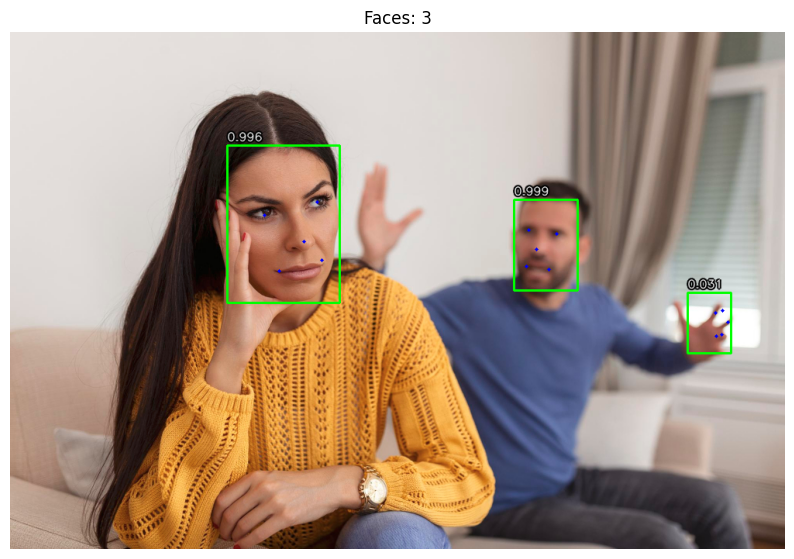

Bounding boxes [x1,y1,x2,y2]: [(650, 216, 732, 333), (280, 146, 425, 349), (874, 336, 930, 414)]
Face 1: {'score': 0.9988014698028564, 'landmarks_5': [[669.1038208007812, 255.33468627929688], [705.033447265625, 260.3373718261719], [679.2428588867188, 280.4052429199219], [666.5391845703125, 302.375732421875], [695.1943969726562, 306.3592224121094]]}
Face 2: {'score': 0.9963077306747437, 'landmarks_5': [[328.325927734375, 236.17344665527344], [396.451416015625, 219.1824951171875], [379.5165710449219, 270.1572265625], [347.7281188964844, 308.7834167480469], [402.0044250488281, 294.7349548339844]]}
Face 3: {'score': 0.031434766948223114, 'landmarks_5': [[910.0667114257812, 362.91571044921875], [919.6871337890625, 359.92620849609375], [926.41259765625, 374.8656005859375], [911.266357421875, 392.48223876953125], [918.9915161132812, 390.16162109375]]}


In [2]:
image_path = "./dataset/images/arguing.jpg"
device = "cuda"

detector = FaceDetector(model_path="./weights/Alignment_RetinaFace.pth", device=device)

_, dets = detector.get_face(image_path)
if len(dets)==0:
    print("No faces detected.")
else:
    img_bgr = cv2.imread(image_path)
    h, w = img_bgr.shape[:2]
    vis = img_bgr.copy()

    boxes = []
    for i, det in enumerate(dets):
        # Expected RetinaFace-style: [x1,y1,x2,y2,score, lmk(10)?]
        x1, y1, x2, y2 = map(int, det[:4])
        score = float(det[4]) if len(det) > 4 else None
        boxes.append((x1, y1, x2, y2))

        # draw box
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0,255,0), 2)

        # draw 5 landmarks if present
        if len(det) >= 15:
            lm = det[5:15].reshape(-1,2)
            for (lx, ly) in lm.astype(int):
                cv2.circle(vis, (lx, ly), 2, (255,0,0), -1)

        # label with confidence
        if score is not None:
            cv2.putText(vis, f"{score:.3f}", (x1, max(0,y1-6)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 3, cv2.LINE_AA)
            cv2.putText(vis, f"{score:.3f}", (x1, max(0,y1-6)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

    # Show in notebook (RGB)
    plt.figure(figsize=(10,7))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Faces: {len(dets)}")
    plt.show()

    # Print details
    print("Bounding boxes [x1,y1,x2,y2]:", boxes)
    for i, det in enumerate(dets):
        info = {"score": float(det[4]) if len(det) > 4 else None}
        if len(det) >= 15:
            info["landmarks_5"] = det[5:15].reshape(-1,2).tolist()
        print(f"Face {i+1}:", info)